this notebook is devoted exclusively toward implementing the q-learning algorithm against the warehouse problem

In [ ]:
#import libraries
import numpy as np
import pandas as pd
import random
import time
import matplotlib.pyplot as plt

In [2]:
#define the shape of the environment (i.e., its states)


#file= open("data/myworld.csv")
file= open("data/world01.csv")

world = np.array([list( s.strip().split(",")) for s in file.readlines()])
file.close()
world=world.astype(float)
environment_rows = world.shape[0]
environment_columns = world.shape[1]
goal_state=[]
terminal_states=[]  #used
for r in range(environment_rows):
    for c in range(environment_columns):
        if world[r][c]==100:
            goal_state.append((r,c))
        if abs(world[r][c])==100:
            terminal_states.append((r,c))
rewards=world
#Create a 3D numpy array to hold the current Q-values for each state and action pair: Q(s, a) 
#The array contains 11 rows and 11 columns (to match the shape of the environment), as well as a third "action" dimension.
#The "action" dimension consists of 4 layers that will allow us to keep track of the Q-values for each possible action in
#each state (see next cell for a description of possible actions). 
#The value of each (state, action) pair is initialized to 0.


#define actions
#numeric action codes: 0 = up, 1 = right, 2 = down, 3 = left
actions = ['up', 'right', 'down', 'left']



In [10]:
q_values = np.zeros((environment_rows, environment_columns, 4))
#define a function that determines if the specified location is a terminal state
def is_terminal_state(current_row_index, current_column_index):
  #if the reward for this location is -1, then it is not a terminal state (i.e., it is a 'white square')
  if rewards[current_row_index, current_column_index] == -1.:
    return False
  else:
    return True

#define a function that will choose a random, non-terminal starting location
def get_starting_location():
  #get a random row and column index
  current_row_index = np.random.randint(environment_rows)
  current_column_index = np.random.randint(environment_columns)
  #continue choosing random row and column indexes until a non-terminal state is identified
  #(i.e., until the chosen state is a 'white square').
  while is_terminal_state(current_row_index, current_column_index):
    current_row_index = np.random.randint(environment_rows)
    current_column_index = np.random.randint(environment_columns)
  return current_row_index, current_column_index

#define an epsilon greedy algorithm that will choose which action to take next (i.e., where to move next)
def get_next_action(current_row_index, current_column_index, epsilon):
  #if a randomly chosen value between 0 and 1 is less than epsilon, 
  #then choose the most promising value from the Q-table for this state.
  if np.random.random() < epsilon:
    return np.argmax(q_values[current_row_index, current_column_index])
  else: #choose a random action
    return np.random.randint(4)

#define a function that will get the next location based on the chosen action
def get_next_location(current_row_index, current_column_index, action_index):
  new_row_index = current_row_index
  new_column_index = current_column_index
  if actions[action_index] == 'up' and current_row_index > 0:
    new_row_index -= 1
  elif actions[action_index] == 'right' and current_column_index < environment_columns - 1:
    new_column_index += 1
  elif actions[action_index] == 'down' and current_row_index < environment_rows - 1:
    new_row_index += 1
  elif actions[action_index] == 'left' and current_column_index > 0:
    new_column_index -= 1
  return new_row_index, new_column_index

#Define a function that will get the shortest path between any location within the warehouse that 
#the robot is allowed to travel and the item packaging location.
def get_shortest_path(start_row_index, start_column_index):
  #return immediately if this is an invalid starting location
  if is_terminal_state(start_row_index, start_column_index):
    return []
  else: #if this is a 'legal' starting location
    current_row_index, current_column_index = start_row_index, start_column_index
    shortest_path = []
    shortest_path.append([current_row_index, current_column_index])
    #continue moving along the path until we reach the goal (i.e., the item packaging location)
    while not is_terminal_state(current_row_index, current_column_index):
      #get the best action to take
      action_index = get_next_action(current_row_index, current_column_index, 1.)
      #move to the next location on the path, and add the new location to the list
      current_row_index, current_column_index = get_next_location(current_row_index, current_column_index, action_index)
      shortest_path.append([current_row_index, current_column_index])
    return shortest_path

#define training parameters
epsilon = 0.9 #the percentage of time when we should take the best action (instead of a random action)
discount_factor = 0.9 #discount factor for future rewards
learning_rate = 0.9 #the rate at which the AI agent should learn

learning=[]
#run through 1000 training episodes
tic = time.perf_counter()
for episode in range(100):
    epoch_size=1000
    epoch_learning=0
    for epoch in range(epoch_size):  
        row_index, column_index = get_starting_location()
        #row_index, column_index=39,0
        while not is_terminal_state(row_index, column_index):
            #choose which action to take (i.e., where to move next)
            action_index = get_next_action(row_index, column_index, epsilon)

            #perform the chosen action, and transition to the next state (i.e., move to the next location)
            old_row_index, old_column_index = row_index, column_index #store the old row and column indexes
            row_index, column_index = get_next_location(row_index, column_index, action_index)
    
            #receive the reward for moving to the new state, and calculate the temporal difference
            reward = rewards[row_index, column_index]
            old_q_value = q_values[old_row_index, old_column_index, action_index]
            temporal_difference = reward + (discount_factor * np.max(q_values[row_index, column_index])) - old_q_value

            #update the Q-value for the previous state and action pair
            new_q_value = old_q_value + (learning_rate * temporal_difference)
            epoch_learning=epoch_learning+reward
            q_values[old_row_index, old_column_index, action_index] = new_q_value
    learning.append(epoch_learning/epoch_size)
print('Training complete!')
toc = time.perf_counter()
print(f"Q-learning converged in {toc - tic:0.4f} seconds")

Training complete!
Q-learning converged in 57.3563 seconds


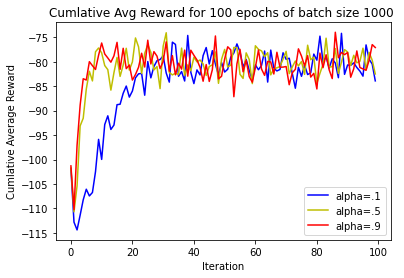

In [11]:
#learning1=learning #55.94
#learning5=learning #56.63
learning9=learning #57.35
ax=plt.axes()
plt.plot(learning1, color="b", label="alpha=.1")
plt.plot(learning5, color="y", label="alpha=.5")
plt.plot(learning9, color="r", label="alpha=.9")

plt.ylabel('Cumlative Average Reward')
plt.xlabel('Iteration')
plt.title("Cumlative Avg Reward for 100 epochs of batch size 1000 ")
plt.legend(loc="best")
plt.show()    

In [9]:
class bcolors:
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
print(f"{bcolors.FAIL}Warning: No active frommets remain. Continue?{bcolors.ENDC}")

direction_mat=[[0 for x in range(environment_columns)] for y in range(environment_rows)] 
raw_mat=[[0 for x in range(environment_columns)] for y in range(environment_rows)] 
for r in range(environment_rows):
        for c in range(environment_columns):
                a=np.argmax(q_values[r][c])
                coord=(r,c)
                if coord in goal_state:
                    direction_mat[r][c]="G"
                    raw_mat[r][c]=0
                elif coord in terminal_states:
                    direction_mat[r][c]="*"
                    raw_mat[r][c]=0
                elif a==0:
                    direction_mat[r][c]='\u2191'
                    raw_mat[r][c]=0
                elif a==1:
                    direction_mat[r][c]='\u2192'
                    raw_mat[r][c]=1
                elif a==2:
                    direction_mat[r][c]='\u2193'
                    raw_mat[r][c]=2
                elif a==3:
                    direction_mat[r][c]='\u2190'
                    raw_mat[r][c]=3
                else:
                    direction_mat[r][c]='err'
#pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
print(pd.DataFrame(direction_mat))

   0  1  2  3  4  5  6  7  8  9   ... 21 22 23 24 25 26 27 28 29 30
0   *  *  *  *  *  G  *  *  *  *  ...  *  *  *  *  *  *  *  *  *  *
1   *  →  →  →  →  ↑  ←  ←  ←  ←  ...  *  *  →  →  →  →  ↓  ←  ←  *
2   *  ↑  *  *  *  *  *  ↑  *  ↑  ...  *  *  *  *  *  *  ↓  *  ↑  *
3   *  ↑  ←  →  →  →  →  ↑  *  ↑  ...  *  *  ↓  ←  →  →  ↓  *  ↑  *
4   *  *  *  ↑  *  *  *  ↑  *  *  ...  *  *  ↓  *  *  *  ↓  *  *  *
5   →  →  →  →  →  →  →  ↑  ←  ←  ...  ←  *  →  →  ↓  ←  ←  ←  ←  ←
6   *  *  *  *  *  ↑  *  *  *  *  ...  *  *  *  *  ↓  *  *  *  *  *
7   *  →  →  →  →  ↑  ←  ←  ←  ←  ...  *  *  *  →  →  →  ↓  ←  ←  *
8   *  *  *  ↑  *  *  *  ↑  *  *  ...  *  *  ↓  *  *  *  ↓  *  *  *
9   →  →  →  ↑  ←  →  →  ↑  ←  ←  ...  ←  *  →  →  ↓  ←  ←  ←  ←  ←
10  *  *  *  *  *  ↑  *  *  *  *  ...  *  *  *  *  ↓  *  *  *  *  *
11  →  →  →  →  →  ↑  ←  ←  ←  ←  ...  ←  *  →  →  ↓  ←  ←  ←  ←  ←
12  *  *  *  *  *  ↑  *  *  *  *  ...  *  *  *  *  ↓  *  *  *  *  *
13  *  →  →  →  →  ↑  ←  ←  ←  ←  ...  ←  ←  ←  

In [6]:
A=pd.DataFrame(direction_mat)

In [7]:

def color_red(val):
    color='black' if val=="*" else 'red'
    return 'color: %s' % color
s=A.style.applymap(color_red)

#def boldv(val):
#    bold='font-weight: bold;'
#    return bold
#s=A.style.applymap(boldv)
s

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,*,*,*,*,*,G,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*
1,*,→,→,→,→,↑,←,←,←,←,*,*,↓,←,→,→,→,→,↓,←,←,*,*,→,→,→,→,↓,←,←,*
2,*,↑,*,*,*,*,*,↑,*,↑,*,*,↓,*,*,*,*,*,↓,*,↑,*,*,*,*,*,*,↓,*,↑,*
3,*,↑,←,→,→,→,→,↑,*,↑,*,*,→,→,↓,←,→,→,↓,*,↑,*,*,↓,←,→,→,↓,*,↑,*
4,*,*,*,↑,*,*,*,↑,*,*,*,*,*,*,↓,*,*,*,↓,*,*,*,*,↓,*,*,*,↓,*,*,*
5,→,→,→,→,→,→,→,↑,←,←,←,*,→,→,→,→,↓,←,←,←,←,←,*,→,→,↓,←,←,←,←,←
6,*,*,*,*,*,↑,*,*,*,*,*,*,*,*,*,*,↓,*,*,*,*,*,*,*,*,↓,*,*,*,*,*
7,*,→,→,→,→,↑,←,←,←,←,*,*,→,→,↓,←,←,←,←,←,←,*,*,*,→,→,→,↓,←,←,*
8,*,*,*,↑,*,*,*,↑,*,*,*,*,*,*,↓,*,*,*,↓,*,*,*,*,↓,*,*,*,↓,*,*,*
9,→,→,→,↑,←,←,→,↑,←,←,←,←,←,←,←,←,←,←,←,←,←,←,*,→,→,↓,←,←,←,←,←
